<h1>Data preparation</h1>

In [2]:
import pandas as pd
data = pd.read_csv("cybersecurity_attacks.csv")

<h2>Time Stamp</h2>

Making timestamp column atomic.

In [5]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format="%Y-%m-%d %H:%M:%S")
data['Year'] = data['Timestamp'].dt.year
data['Month'] = data['Timestamp'].dt.month
data['Day'] = data['Timestamp'].dt.day
data['Hour'] = data['Timestamp'].dt.hour + (data['Timestamp'].dt.minute/60) + (data['Timestamp'].dt.second/3600)
data = data.drop(columns=['Timestamp'])

<h2>IP Addresses</h2>

Get localisation and organisation information from IP Addresses, thanks to GeoLite2 databases.

In [9]:
import geoip2.database

city_reader = geoip2.database.Reader('GeoLite2-City.mmdb')
asn_reader = geoip2.database.Reader('GeoLite2-ASN.mmdb')

def get_ip_details(ip):
    
    asn_num, asn_org, city, country, lat, long = None, None, None, None, None, None

    try:
        city_res = city_reader.city(ip)
        asn_res = asn_reader.asn(ip)
        
        asn_num = asn_res.autonomous_system_number
        asn_org = asn_res.autonomous_system_organization
        city = city_res.city.name
        country = city_res.country.name
        lat = city_res.location.latitude
        long = city_res.location.longitude

    except Exception as e:
        pass 

    return pd.Series([asn_num, asn_org, city, country, lat, long])

In [11]:
data[['asn_num Source', 'asn_org Source', 'city Source', 'country Source', 'lat Source', 'long Source']] = data['Source IP Address'].apply(get_ip_details)

In [12]:
data[['asn_num Destination', 'asn_org Destination', 'city Destination', 'country Destination', 'lat Destination', 'long Destination']] = data['Destination IP Address'].apply(get_ip_details)

Categorise organisation by name, using keywords. This method is not exhaustive nor exact but easy to implement.

In [17]:
def classify_asn(org_name):
    org_name = str(org_name).lower()
    
    if any(k in org_name for k in ['google', 'amazon', 'aws', 'microsoft', 'azure', 'oracle', 'ibm', 'alibaba', # Giants
                                    'ovh', 'hetzner', 'digitalocean', 'linode', 'vultr', 'contabo', 'scaleway', 'clouvider',  # Hosts
                                    'akamai', 'cloudflare', 'fastly', 'leaseweb', 'equinix', 'rackspace',         # CDN
                                    'hosting', 'cloud', 'datacenter', 'vps', 'server', 'compute', 'softlayer'    # General
                                  ]  ):
        return 'Cloud/Hosting'

    if any(k in org_name for k in ['telecom', 'telekom', 'telecoms', 'provider', 'broadband', 'communication', 'communications',
    'mobile', 'wireless', 'network', 'online', 'internet',
    'orange', 'proxad', 'free', 'sfr', 'numericable', 'cegetel', 'bouygues', 
    'comcast', 'verizon', 'at&t', 't-mobile', 'vodafone', 'charter', 'spectrum',
    'cox', 'centurytel', 'frontier', 'bt-central', 'telefonica', 'deutsche telekom',
    'chinanet', 'unicom', 'reliance', 'jio', 'airtel', 'ntt', 'kpn', 'bredband2', 'te data', 'videotron']):
       
        return 'Internet Provider'
    
    if any(k in org_name for k in ['academy', 'university', 'college', 'research', 'education', 'state', 'department', 'institute', 'ministry', 'ministere', 'administration', 
    'council',  'defense', 'military', 'national', 'regione', 'headquarters', 'district',
    'city of', 'uninet']):
        return 'Education/Gov'
    
    if any(k in org_name for k in ['holding', 'bank', 'corp', 'inc', 'ltd', 'llc', 'company', 'co.', 'corporation', 's.a', 'sa', 'as', 'a.s', 'a.d', 'ad', 'ag', 'a.g', 'gmbh', 'ltda', 's.a.u'
                                  'insurance', 'industries', 'logistics', 'srl', 's.r.l']):
        return 'Enterprise'
        
    return 'Enterprise'

data['asn_source type'] = data['asn_org Source'].apply(classify_asn)
data['asn_dest type'] = data['asn_org Destination'].apply(classify_asn)

asn_source type    0
asn_dest type      0
dtype: int64
asn_source type
Enterprise           16717
Internet Provider    14992
Education/Gov         4523
Cloud/Hosting         3768
Name: count, dtype: int64


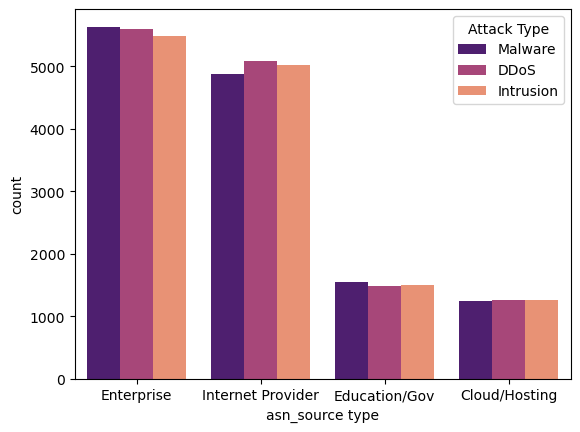

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

print(data[['asn_source type', 'asn_dest type']].isna().sum())
counts = data['asn_source type'].value_counts()
print(counts)

sns.countplot(data=data, x='asn_source type', hue='Attack Type', palette='magma')
plt.show()

We don't keep ASN organisation because same info as ASN  number et we categorised it to keep it simpler.
A lot of missing values for city (21000) so we drop it because we can't infer it.

In [22]:
data.drop(['asn_org Destination', 'asn_org Source', 'city Destination', 'city Source'], axis=1, inplace=True)

Trying to get more info from IP Addresses, thanks to ipaddress library.

In [26]:
import ipaddress

def get_info_from_ip(ip_string):
    ip = ipaddress.ip_address(ip_string)
    return pd.Series([ip.version, ip.is_private, ip.is_global, ip.is_link_local, ip.is_loopback, ip.is_multicast, ip.is_reserved, ip.is_unspecified, int(ip)])

In [28]:
data[["Destination IP Version", "Destination IP Private", "Destination IP Global", "Destination IP Link Local", "Destination IP loopback", "Destination IP Multicast", "Destination IP Reserved", "Destination IP Unspecified", "Destination IP Int"]] = data["Destination IP Address"].apply(get_info_from_ip)

In [30]:
print(data[["Destination IP Version", "Destination IP Private", "Destination IP Global", "Destination IP Link Local", "Destination IP loopback", "Destination IP Multicast", "Destination IP Reserved", "Destination IP Unspecified", "Destination IP Int"]].isna().sum())


print(data['Destination IP Version'].nunique())
print(data['Destination IP Private'].nunique())
print(data['Destination IP Global'].nunique())
print(data['Destination IP Link Local'].nunique())
print(data['Destination IP loopback'].nunique())
print(data['Destination IP Multicast'].nunique())
print(data['Destination IP Reserved'].nunique())
print(data['Destination IP Unspecified'].nunique())
print(data['Destination IP Int'].nunique())

print(data['Destination IP Version'].unique())
print(data['Destination IP Private'].unique())
print(data['Destination IP Global'].unique())
print(data['Destination IP Link Local'].unique())
print(data['Destination IP loopback'].unique())
print(data['Destination IP Multicast'].unique())
print(data['Destination IP Reserved'].unique())
print(data['Destination IP Unspecified'].unique())
print(data['Destination IP Int'].unique())

Destination IP Version        0
Destination IP Private        0
Destination IP Global         0
Destination IP Link Local     0
Destination IP loopback       0
Destination IP Multicast      0
Destination IP Reserved       0
Destination IP Unspecified    0
Destination IP Int            0
dtype: int64
1
2
2
1
1
1
1
1
40000
[4]
[False  True]
[ True False]
[False]
[False]
[False]
[False]
[False]
[1409918204 1119848858 3336262161 ... 1651179535 2907664636 1841704199]


In [32]:
data[["Source IP Version", "Source IP Private", "Source IP Global", "Source IP Link Local", "Source IP loopback", "Source IP Multicast", "Source IP Reserved", "Source IP Unspecified", "Source IP Int"]] = data["Source IP Address"].apply(get_info_from_ip)

Only interesting values : IP Private (exact opposite of IP Global) and IP Int so we keep those 2 columns: other features only has one value so they are not informative.

In [35]:
col_dest = ["Destination IP Version", "Destination IP Global", "Destination IP Link Local", "Destination IP loopback", "Destination IP Multicast", "Destination IP Reserved", "Destination IP Unspecified"]
col_src = ["Source IP Version", "Source IP Global", "Source IP Link Local", "Source IP loopback", "Source IP Multicast", "Source IP Reserved", "Source IP Unspecified"]

data.drop(col_dest, axis=1, inplace=True)
data.drop(col_src, axis=1, inplace=True)

Splitting IP Adresses in each octet. This is sometimes done in Cyber Security analysis to improve learning.

In [40]:
data[['octet1 Source', 'octet2 Source', 'octet3 Source', 'octet4 Source']] = data['Source IP Address'].str.split('.', expand=True).astype(int)
data[['octet1 Destination', 'octet2 Destination', 'octet3 Destination', 'octet4 Destination']] = data['Destination IP Address'].str.split('.', expand=True).astype(int)

In [42]:
data.drop(columns=['Source IP Address', 'Destination IP Address'], axis=1, inplace=True)

Calculating distance between Source and Destination.

In [44]:
import numpy as np

def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371.0 

    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi / 2.0)**2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2.0)**2
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

data['dist Source/Dest'] = haversine_np(
    data['lat Source'], data['long Source'], 
    data['lat Destination'], data['long Destination']
)

<h2>Ports</h2>

Categorise ports as seen on: https://en.wikipedia.org/wiki/List_of_TCP_and_UDP_port_numbers.

In [49]:
def port_category(port):
    if 0 <= port <= 1023:
        return "Well Known"
    elif 1024 <= port <= 49151:
        return "Registered"
    elif 49152 <= port <= 65535:
        return "Ephemeral"

data["Categorical Source Port"] = data["Source Port"].apply(port_category)
data["Categorical Destination Port"] = data["Destination Port"].apply(port_category)

<h2>Payload Data</h2>

Infer length and entropy because these features are often used in Cyber Security applications.

In [53]:
data["len payload"] = data["Payload Data"].str.len()

In [55]:
import numpy as np
from collections import Counter


def entropy(string):
    
    if len(string) == 0:
        return 0
    
    counts = Counter(string)
    total = sum(counts.values())
    probs = np.array([c / total for c in counts.values()])


    return -(probs * np.log2(probs)).sum()
    

data["entropy payload"] = data["Payload Data"].apply(entropy)

In [56]:
data.drop(columns=['Payload Data'], axis=1, inplace=True)

Contvert columns as binary variables.

In [60]:
data['Malware Indicators'] = data['Malware Indicators'].notna().astype(int)
data['Alerts/Warnings'] = data['Alerts/Warnings'].notna().astype(int)

User information provide name of victims: it has nothing to do with Attack Type so we drop the column.

In [65]:
data.drop(columns=['User Information'], axis=1, inplace=True)

KeyError: "['User Information'] not found in axis"

<h2>Device Information</h2>

Parse info from Device Info to make column atomic.

In [72]:
from ua_parser import parse

def parse_device_info(ua_string):
    ua = parse(ua_string)
    browser = ua.user_agent.family if ua.user_agent is not None else None
    browser_version = ua.user_agent.major if ua.user_agent is not None else None
    os = ua.os.family if ua.os is not None else None
    os_version = ua.os.major if ua.os is not None else None
    device = ua.device.model if ua.device is not None else "Other"

    s = ua_string.split(")")[1]
    engine = s.split("/")[0]
    engine = engine.replace(" ","")
    if engine == "":
        engine = "Trident"

    return browser, browser_version, os, os_version, device, engine

data[["Browser", "Browser Version", "OS", "OS Version", "Device", "Engine"]] = data['Device Information'].apply(lambda x: pd.Series(parse_device_info(x)))

In [73]:
data.drop(columns=['Device Information'], axis=1, inplace=True)

Making features binary

In [81]:
data['Firewall Logs'] = data['Firewall Logs'].notna().astype(int)
data['IDS/IPS Alerts'] = data['IDS/IPS Alerts'].notna().astype(int)

<h2>Geo location</h2>

Get latitude, longitude and population to enrich Geo location data, thanks to 3 different databases found online.

In [85]:
data["city"] = data["Geo-location Data"].str.split(",", expand=True)[0]
data['state'] = data["Geo-location Data"].str.split(",", expand=True)[1]

data.drop(columns=['Geo-location Data'], axis=1, inplace=True)

In [87]:
data2 = pd.read_csv("worldcities.csv")
data2 = data2[['city_ascii', 'lat', 'lng', 'population', 'country']]
data2 = data2[data2['country']=='India']
data2.drop(columns='country', inplace = True)
data2.columns = ['city', 'lat', 'long', 'pop']
data2 = data2.round(2)

data3 = pd.read_csv("final_cities.csv")
data3 = data3[['City', 'Latitude', 'Longitude', 'Population']]
data3.columns = ['city', 'lat', 'long', 'pop']
data3 = data3.round(2)

columns = ["name", "population", "location"]

fichiers = [
    "place_city.ndjson",
    "place-hamlet.ndjson",
    "place-village.ndjson",
    "place-town.ndjson"
]

datas = [pd.read_json(f, lines=True) for f in fichiers]

data4 = pd.concat(datas, ignore_index=True)
data4 = data4[columns]
data4[["lon", "lat"]] = data4["location"].apply(pd.Series)
data4 = data4[['name', 'lat', 'lon', 'population', 'location']]
data4.drop(columns='location', inplace = True)
data4.columns = ['city', 'lat', 'long', 'pop']
data4 = data4.round(2)

data_cities = pd.concat([data2, data3, data4], ignore_index=True)
before = len(data_cities)
data_cities = data_cities.drop_duplicates()
after = len(data_cities)
print(before-after)

23362


In [88]:
print(data2.head())

         city    lat   long         pop
2       Delhi  28.61  77.23  32226000.0
4      Mumbai  19.08  72.88  24973000.0
10    Kolkata  22.57  88.37  21747000.0
21  Bangalore  12.98  77.59  15386000.0
29    Chennai  13.08  80.28  12395000.0


In [89]:
d2 = data2.drop_duplicates(subset=['city']).set_index('city')
d3 = data3.drop_duplicates(subset=['city']).set_index('city')
d4 = data4.drop_duplicates(subset=['city']).set_index('city')

def find_infos(city):

    cols = ['lat', 'long', 'pop']

    if city in d4.index:
        return d4.loc[city]
    
    elif city in d2.index:
        return d2.loc[city]
    
    elif city in d3.index:
        return d3.loc[city]

    else:
        return pd.Series({c: None for c in cols})

data[['lat', 'long', 'pop']] = data['city'].apply(find_infos)

In [90]:
print(data.isna().sum())

Source Port                         0
Destination Port                    0
Protocol                            0
Packet Length                       0
Packet Type                         0
Traffic Type                        0
Malware Indicators                  0
Anomaly Scores                      0
Alerts/Warnings                     0
Attack Type                         0
Attack Signature                    0
Action Taken                        0
Severity Level                      0
Network Segment                     0
Proxy Information               19851
Firewall Logs                       0
IDS/IPS Alerts                      0
Log Source                          0
Year                                0
Month                               0
Day                                 0
Hour                                0
asn_num Source                   6523
country Source                   6528
lat Source                       6528
long Source                      6528
asn_num Dest

<h2>Proxy</h2>

Apply same treatment as IP Addresses because Proxy is given as an Address.

In [96]:
data[['asn_num Proxy', 'asn_org Proxy', 'city Proxy', 'country Proxy', 'lat Proxy', 'long Proxy']] = data['Proxy Information'].apply(get_ip_details)

In [97]:
print(data['Proxy Information'].isna().sum())
data['Proxy Information'] = data['Proxy Information'].fillna(0)

def get_int_proxy(ip_string):
    ip = ipaddress.ip_address(ip_string)
    return pd.Series([int(ip)])

data['Proxy Information'] = data['Proxy Information'].apply(get_int_proxy)

19851


In [100]:
print(data[['asn_num Proxy', 'asn_org Proxy', 'city Proxy', 'country Proxy', 'lat Proxy', 'long Proxy']].isna().sum())

asn_num Proxy    23162
asn_org Proxy    23162
city Proxy       30914
country Proxy    23164
lat Proxy        23164
long Proxy       23164
dtype: int64


In [102]:
data['asn_proxy type'] = data['asn_org Proxy'].apply(classify_asn)

In [103]:
data.drop(columns=['asn_org Proxy', 'city Proxy'], axis=1, inplace=True)

In [106]:
print(data['Proxy Information'].head(10))

0    2517197191
1             0
2    1921331379
3             0
4    2500226679
5             0
6             0
7    3223297797
8             0
9    1468069364
Name: Proxy Information, dtype: int64


<h2>Save prepared Data</h2>

In [108]:
data.to_csv('extracted data new.csv', index=False)